# Testing Relaxation and Correlation Timescales for Half-System Entropy

This document aims to explore and analyze the relaxation and correlation timescales for the half-system entropy in a given system. The half-system entropy is a measure of the disorder or randomness in a system, specifically focusing on the entropy of half of the system.

In [45]:
using Base.Filesystem  # for creaating directories etc
using Random, Distributions  # random numbers
using HDF5  # hdf5 files
using QuantumClifford  # this is the stabilizer simulation package
using Plots # for plotting
using Formatting # string formatting
using LinearAlgebra # some useful matrices etc.
using StatsBase # for autocorrelations
dep_path = "../AdditionalStructure/Julia/"
include("$(dep_path)NewTypes.jl")
include("$(dep_path)BitStringOps.jl")
include("$(dep_path)Measurements.jl")
include("$(dep_path)MICModels.jl")
include("$(dep_path)ModelRuns.jl")
include("$(dep_path)HelperTools.jl")
include("$(dep_path)Iterators.jl");

In [46]:
function example_run(L::Integer, d::Integer, p_f_arr::Array{Float64}, p_b_arr::Array{Float64}, t_mmt::Array{Int}, subdiv_array::Array{Int})
    """ This is the main function on terminal call.
        The simulation is of Toric Code and we try and measure the Boson and Fermion with some probabilities.
        The main measure is the TEE with a ceratin geometry (Kiatev Donut). 
    """

    system = Init_EdgeSquareLattice_KitaevDoNuT(L, d);
    n_t = length(t_mmt)
    n_pf = length(p_f_arr)
    p_f_indices = 1:n_pf
    n_pb = length(p_b_arr)
    p_b_indices = 1:n_pb
    n_subdiv = length(subdiv_array)

    all_p_arr = collect(Iterators.product(p_f_arr, p_b_arr))
    all_p_indices = collect(Iterators.product(p_f_indices, p_b_indices))
    TEE_array = fill(NaN, n_t, n_pf, n_pb)
    EE_cut_array  = fill(NaN, n_t, n_pf, n_pb, n_subdiv)

    Threads.@threads for loop_index in 1:(n_pf * n_pb)
    # for loop_index in 1:(n_pf * n_pb)
        Indices = all_p_indices[loop_index]
        Probs = all_p_arr[loop_index]
        p_f_index, p_b_index = Indices
        p_f, p_b = Probs
        p_tc = 1 - p_f - p_b
        if p_tc < 0 # Easy fix for scanning the full parameter space triangle. ToDo: Implement a better way to scan the triangle.
            continue
        end
        stab_distro = Categorical([p_tc/2, p_tc/2, p_b, 0, p_f])
        # state = toric_code_GS(system) # Get the pure TC ground state as the initial state
        state = get_random_pure_state(system) # Get a random pure state.
        t_old = 0
        for t_index in 1:n_t
            t_evol = t_mmt[t_index] - t_old
            t_old = t_mmt[t_index]
            state = iterate_measurements_only_fast!(state, system, () -> toric_code(system, stab_distro), t_evol)
            # TEE_array[t_index, p_f_index, p_b_index] = entanglement_entropy_topo(state, system)
            EE_cut_array[t_index, p_f_index, p_b_index, :] = entanglement_entropy_cut(state, system, subdiv_array)
        end
    end

    return EE_cut_array#, TEE_array
end

example_run (generic function with 1 method)

In [47]:
p_f_arr = [0.5]
p_b_arr = [0, 0.1, 0.4]

L = 60
d = 3

t_mmt = Array{Int}(1:10000)
subdiv_array = [30]

# EE_cut_array = example_run(L, d, p_f_arr, p_b_arr, t_mmt, subdiv_array)

1-element Vector{Int64}:
 30

In [48]:
extra = 1
filename = "../Remote-OfficePC/Toric_Code/data/TEE_exp:relax_$(extra).h5"
data_1 = h5read(filename, "/")

extra = 2
filename = "../Remote-OfficePC/Toric_Code/data/TEE_exp:relax_$(extra).h5"
data_2 = h5read(filename, "/")

extra = 3
filename = "../Remote-OfficePC/Toric_Code/data/TEE_exp:relax_$(extra).h5"
data_3 = h5read(filename, "/")

Dict{String, Any} with 7 entries:
  "d"        => 3
  "t_mmt"    => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  991, 992, 993, 994, 995, 996…
  "p_b_arr"  => [0.4]
  "filename" => "/home/j/jovanovic/GitHub/Subsystem-Code-Physics/Remote-OfficeP…
  "L"        => 60
  "p_f_arr"  => [0.5]
  "EE_cut"   => [1706.0; 988.0; … ; 21.0; 22.0;;;;]

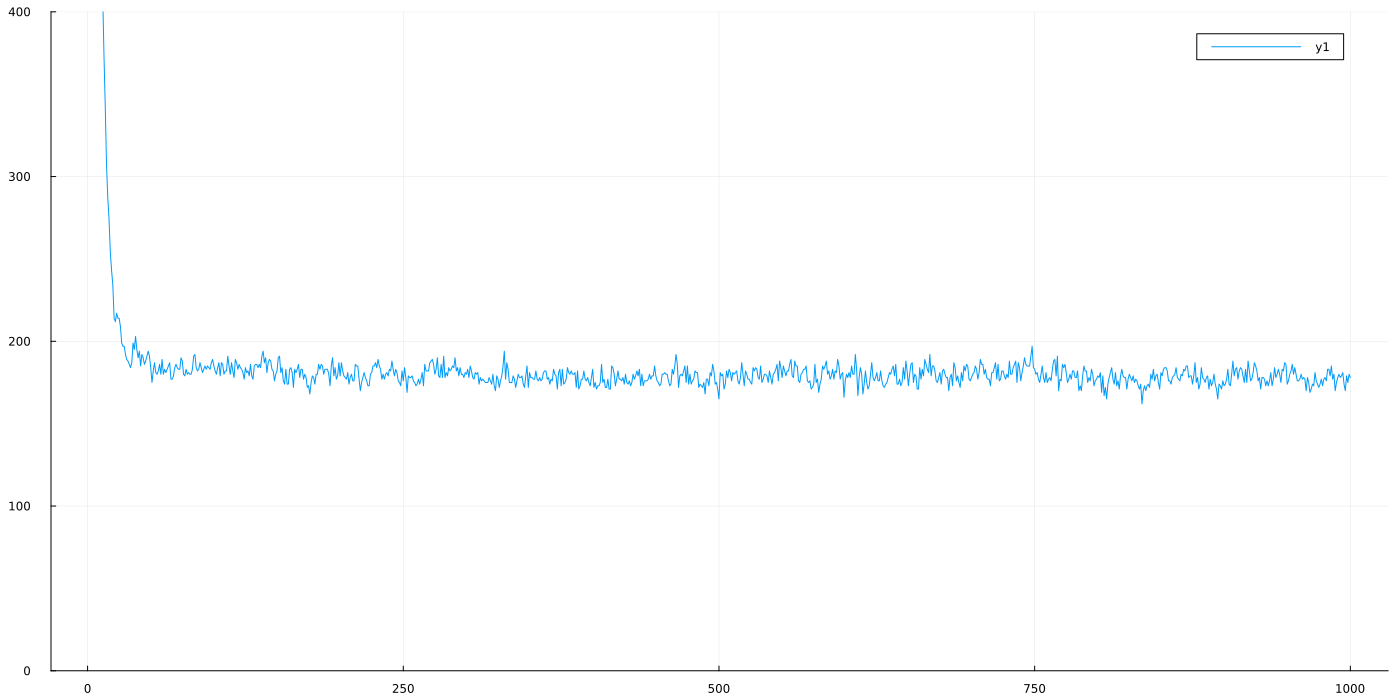

In [49]:
plot(data_1["t_mmt"], data_1["EE_cut"][:,1,1,1], ylims=(0, 400), size = (1400, 700))

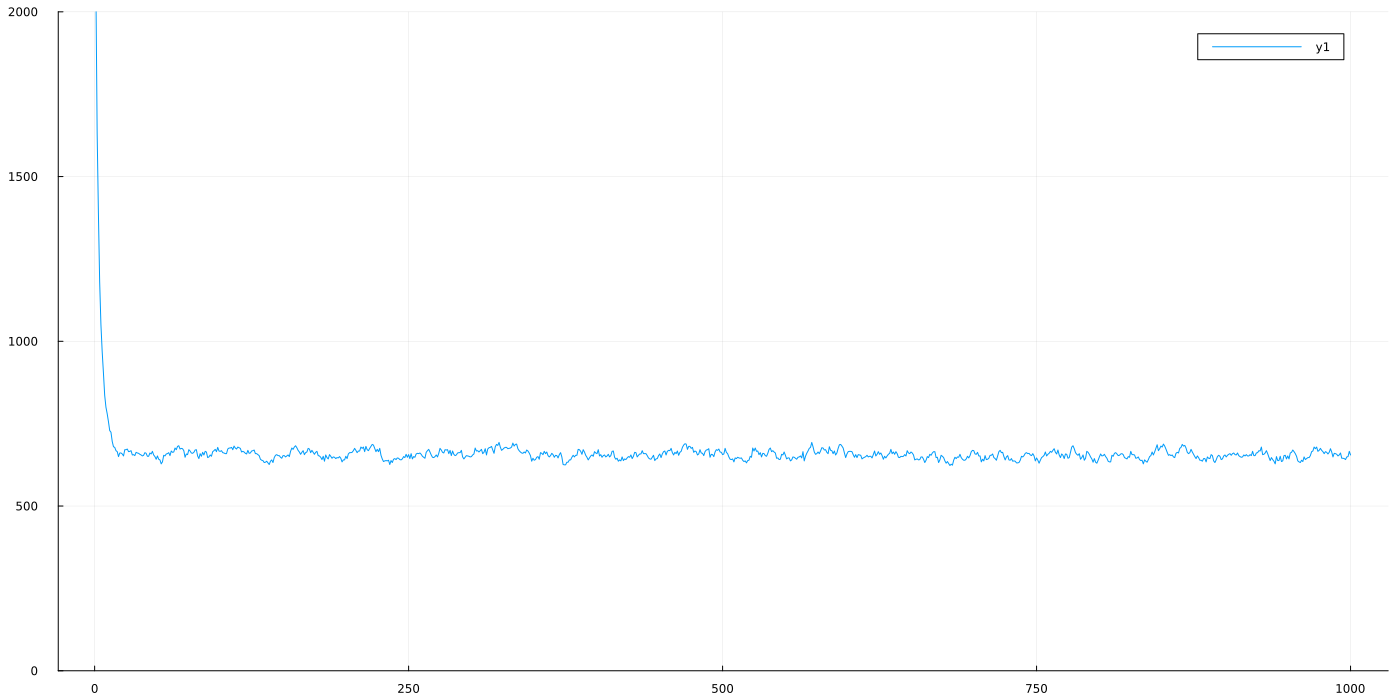

In [50]:
plot(data_2["t_mmt"], data_2["EE_cut"][:,1,1,1], ylims=(0, 2000), size = (1400, 700))

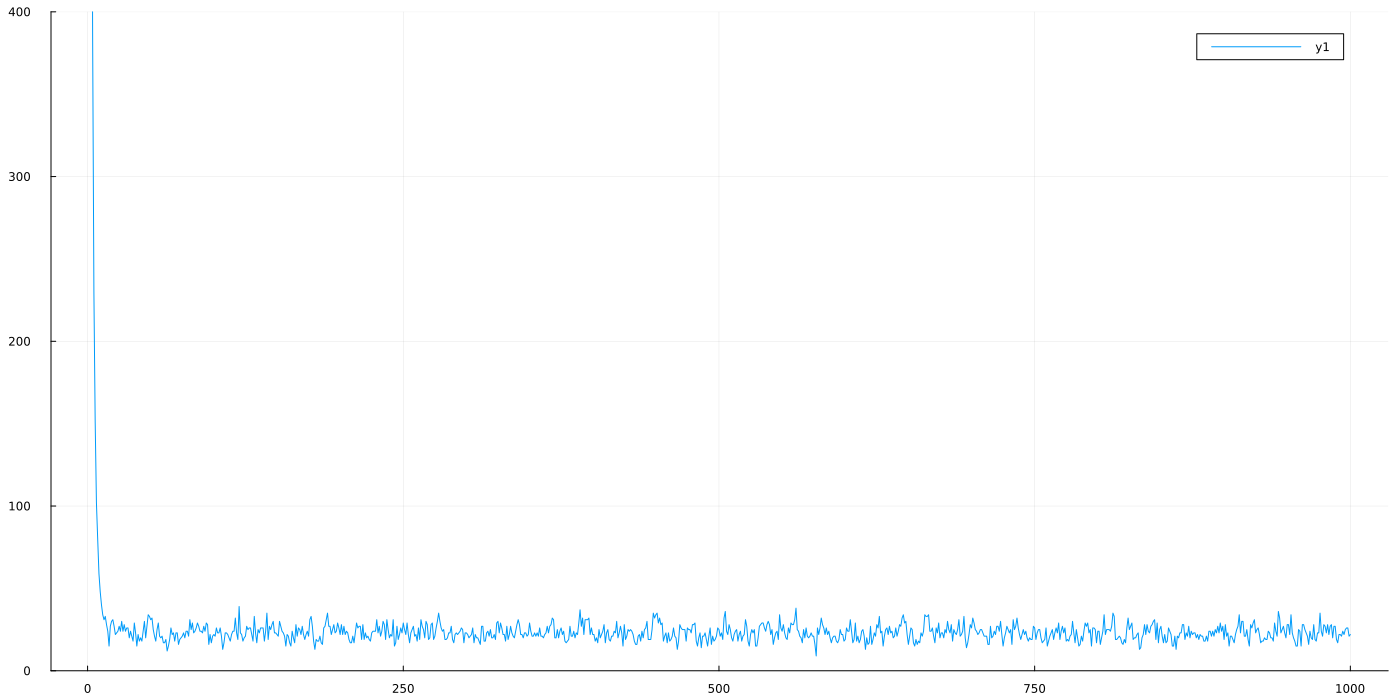

In [51]:
plot(data_3["t_mmt"], data_3["EE_cut"][:,1,1,1], ylims=(0, 400), size = (1400, 700))

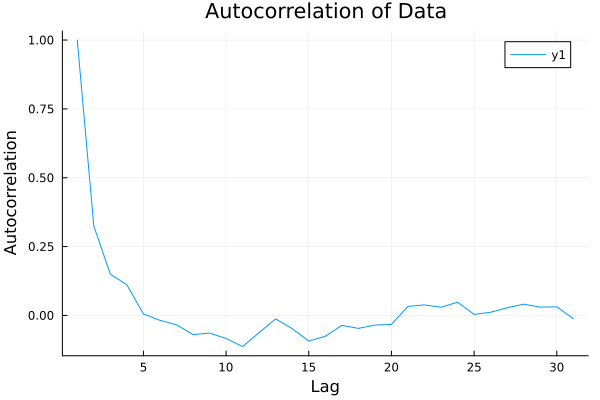

In [52]:
autocorr = autocor(data_3["EE_cut"][50:end,1,1,1])
plot(autocorr, xlabel="Lag", ylabel="Autocorrelation", title="Autocorrelation of Data")


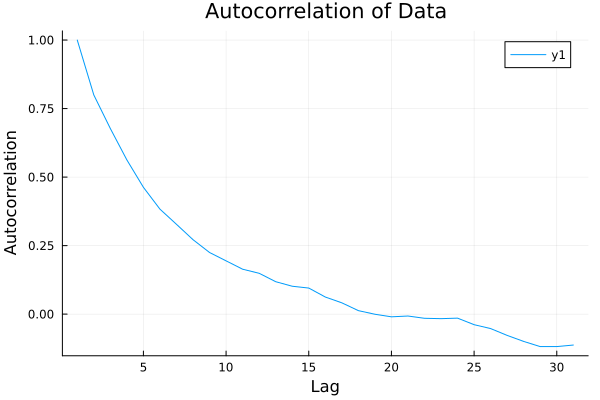

In [53]:
autocorr = autocor(data_2["EE_cut"][50:end,1,1,1])
plot(autocorr, xlabel="Lag", ylabel="Autocorrelation", title="Autocorrelation of Data")

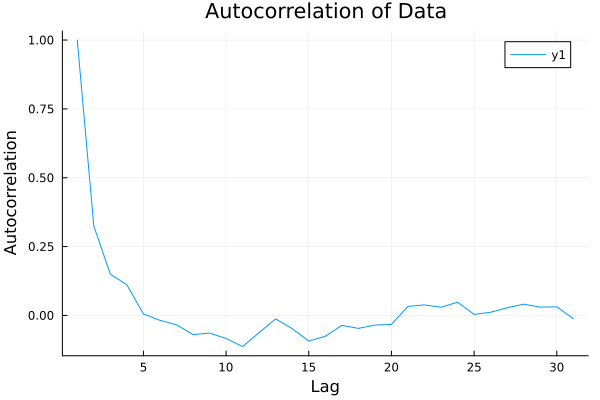

In [54]:
autocorr = autocor(data_3["EE_cut"][50:end,1,1,1])
plot(autocorr, xlabel="Lag", ylabel="Autocorrelation", title="Autocorrelation of Data")

In [55]:
extra = 4
filename = "../Remote-OfficePC/Toric_Code/data/TEE_exp:relax_$(extra).h5"
data_4 = h5read(filename, "/")

extra = 5
filename = "../Remote-OfficePC/Toric_Code/data/TEE_exp:relax_$(extra).h5"
data_5 = h5read(filename, "/")

extra = 6
filename = "../Remote-OfficePC/Toric_Code/data/TEE_exp:relax_$(extra).h5"
data_6 = h5read(filename, "/")

Dict{String, Any} with 7 entries:
  "d"        => 3
  "t_mmt"    => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  991, 992, 993, 994, 995, 996…
  "p_b_arr"  => [0.35]
  "filename" => "/Users/jovanjovanovic/GitHub/Subsystem-Code-Physics/Remote-Off…
  "L"        => 24
  "p_f_arr"  => [0.55]
  "EE_cut"   => [284.0; 161.0; … ; 12.0; 13.0;;;;]

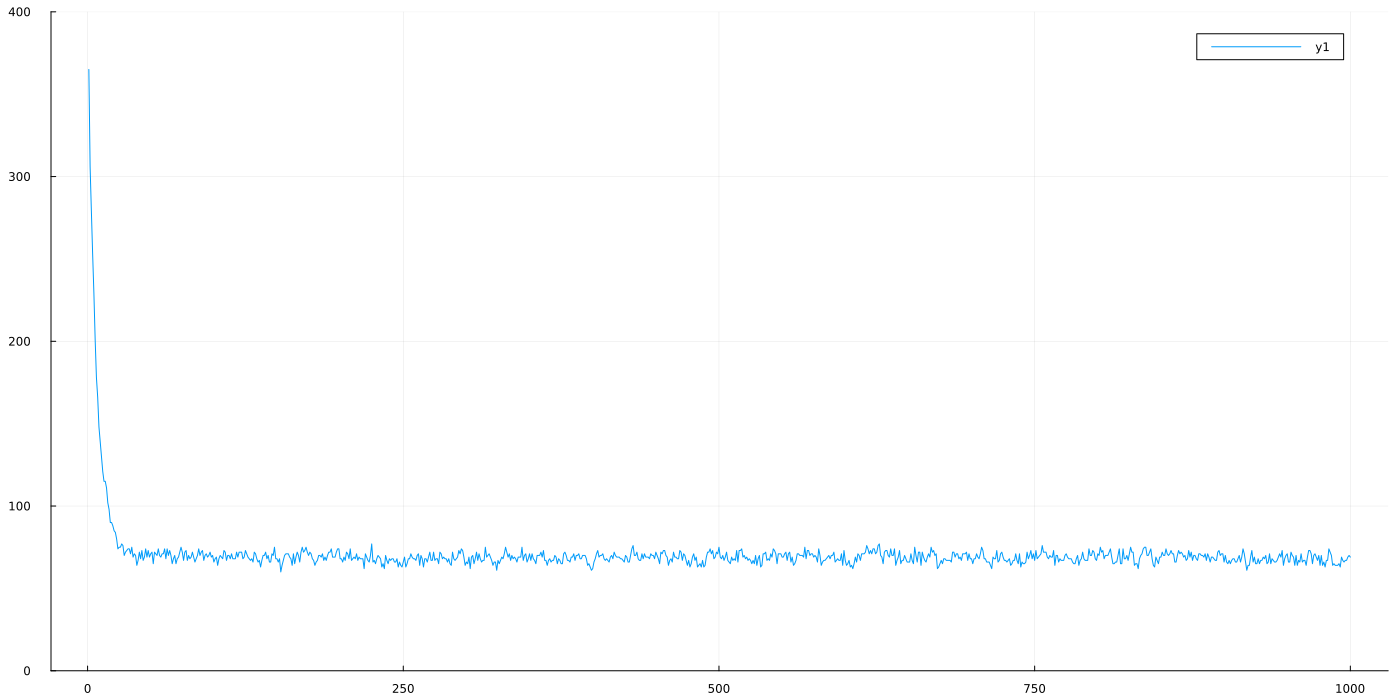

In [56]:
plot(data_4["t_mmt"], data_4["EE_cut"][:,1,1,1], ylims=(0, 400), size = (1400, 700))

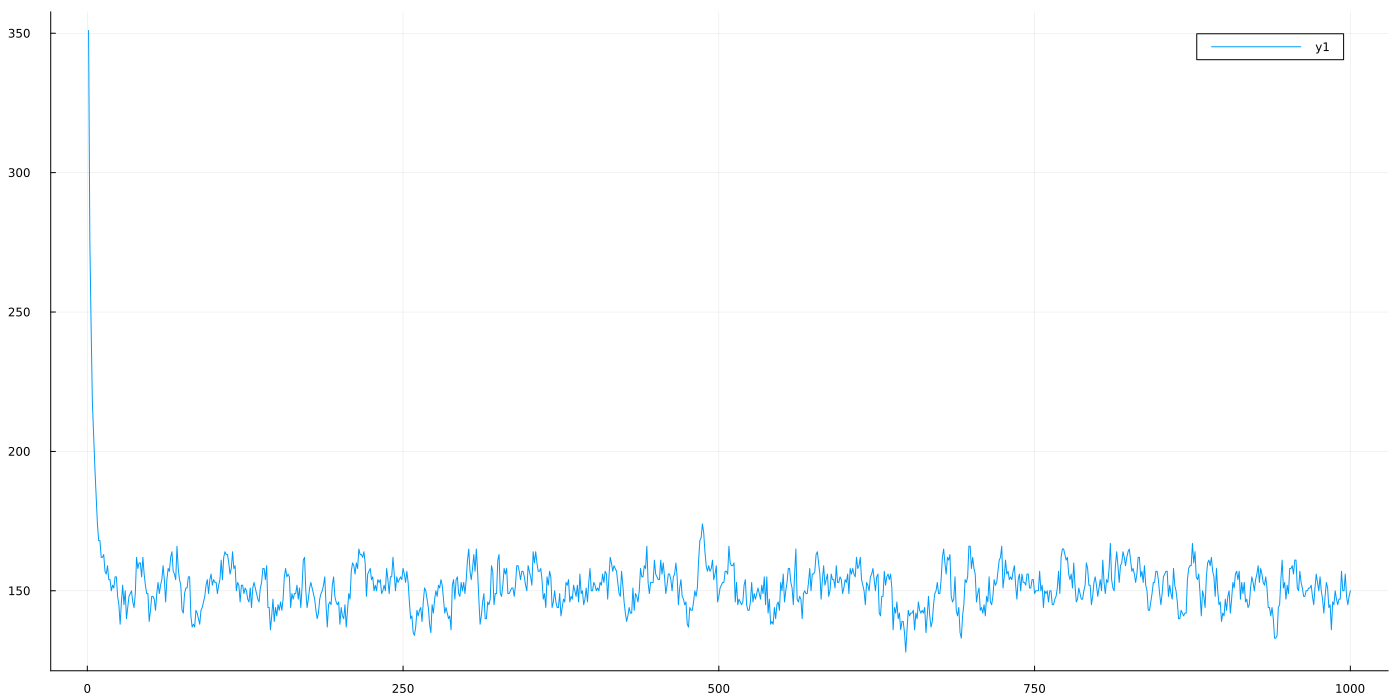

In [57]:
plot(data_5["t_mmt"], data_5["EE_cut"][:,1,1,1], size = (1400, 700))

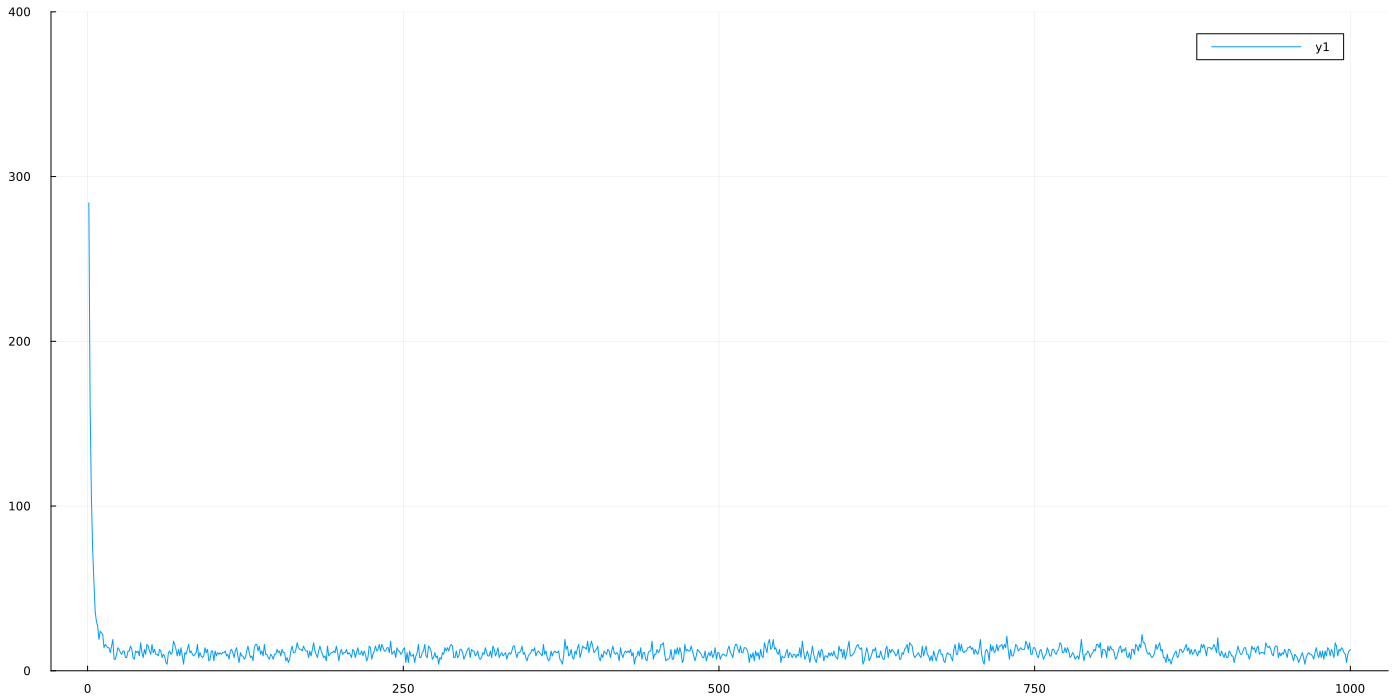

In [58]:
plot(data_6["t_mmt"], data_6["EE_cut"][:,1,1,1], ylims=(0, 400), size = (1400, 700))

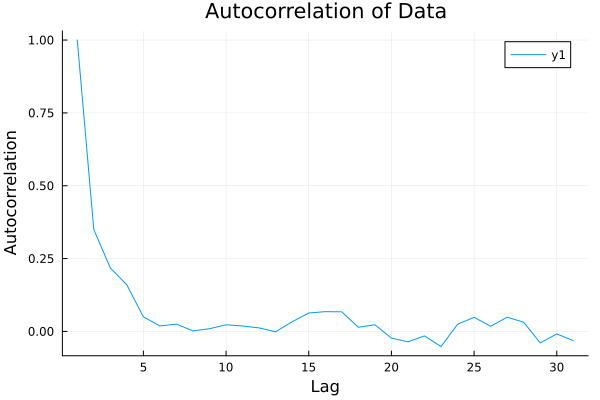

In [59]:
autocorr = autocor(data_4["EE_cut"][50:end,1,1,1])
plot(autocorr, xlabel="Lag", ylabel="Autocorrelation", title="Autocorrelation of Data")

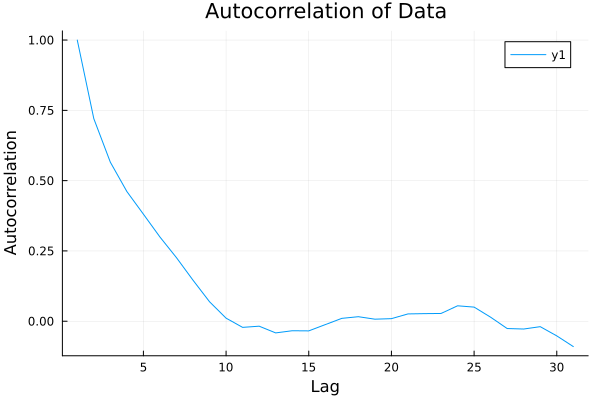

In [60]:
autocorr = autocor(data_5["EE_cut"][50:end,1,1,1])
plot(autocorr, xlabel="Lag", ylabel="Autocorrelation", title="Autocorrelation of Data")

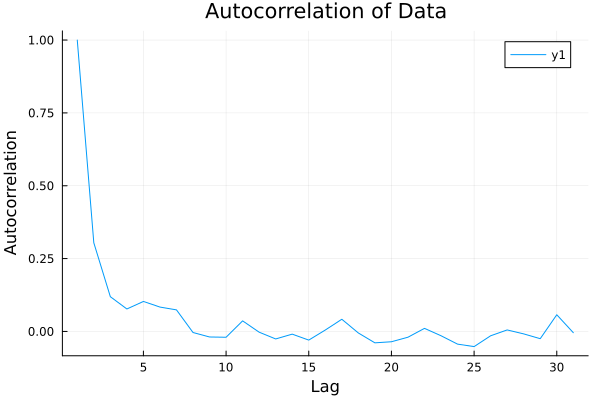

In [61]:
autocorr = autocor(data_6["EE_cut"][50:end,1,1,1])
plot(autocorr, xlabel="Lag", ylabel="Autocorrelation", title="Autocorrelation of Data")